In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-tweets-2022/tweets-1.csv
/kaggle/input/bitcoin-tweets-2022/tweets-6.csv
/kaggle/input/bitcoin-tweets-2022/tweets.csv
/kaggle/input/bitcoin-tweets-2022/tweets-5.csv
/kaggle/input/bitcoin-tweets-2022/tweets-4.csv
/kaggle/input/bitcoin-tweets-2022/tweets-3.csv
/kaggle/input/bitcoin-tweets-2022/tweets-2.csv


# importing all libraries

In [2]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.9 MB/s eta 0:00:0000:0100:010m


In [3]:
!pip install vaderSentiment
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 317.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 2.3 MB/s eta 0:00:00a 0:00:010m


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import MinMaxScaler,normalize
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import time
import datetime

In [5]:
tf.random.set_seed(7)


# preparing sentiment data

In [6]:
vader = SentimentIntensityAnalyzer()

#function for vader sentiment analysis

def apply_vader_on_dataset(dataset_df,column_tweet="Tweet Content"):
    vader_output = dataset_df.apply(lambda x: pd.Series(vader.polarity_scores(x[column_tweet])), axis=1)
    dataset_with_vader = pd.concat([dataset_df, vader_output], axis=1)
    return dataset_with_vader

from tensorflow.keras.utils import to_categorical


def convert_labels_to_one_hot(df, from_compound=False):
    """
    helper function to convert regression labels to one-hot form
    """
    if from_compound:
        df.loc[df['compound'] <= -0.5, 'label'] = 0
        df.loc[(df['compound']<0.5) & (df['compound']>-0.5), 'label'] = 1
        df.loc[df['compound'] >= 0.5, 'label'] = 2
        labels = df['label'].to_numpy()
        df.drop(columns=['label'], inplace=True)
    else:
        labels = df[['neg', 'neu', 'pos']].to_numpy()
        labels = np.argmax(labels, axis=1)
    
    labels = np.array(to_categorical(labels, num_classes=3))
    df.loc[:, ['neg', 'neu', 'pos']] = labels
    
    return df

In [7]:
import string
import re
import nltk
import spacy

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


# Removal of URLs
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


# Removal of HTML tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)


# Removal of mentions
def remove_mentions(text):
    return re.sub("@[A-Za-z0-9_]+","", text)


# Removal of stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


# Stemming
# nothing


# Lemmatization
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


# Removal of Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Removal of emoticons
# todo: nothing


# Conversion of emoticons to words
# todo: nothing


# Conversion of emojis to words
# todo: nothing


# Chat Words Conversion
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)


# Spelling Correction
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    """ its norving method """
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


# Removal of numbers 
def remove_number(text):
    return re.sub("[0-9]+", "", text)


# Removal of Punctuations
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


# remove over spaces
def remove_over_spaces(text):
    return re.sub('\s{2,}', " ", text)


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
def undersample_data(df, neg_num, neu_num, pos_num):
    small_df = pd.DataFrame(columns=df.columns)
    df_by_label = {
        "neg": df[df['compound'] <= -0.5],
        "neu": df[(df['compound'] < 0.5) & (df['compound'] > -0.5)],
        "pos": df[df['compound'] >= 0.5]
    }
    print('neg total num: ', df_by_label['neg'].shape[0])
    print('neu total num: ', df_by_label['neu'].shape[0])
    print('pos total num: ', df_by_label['pos'].shape[0])
    small_df = pd.concat([small_df, df_by_label['neg'].iloc[:neg_num]])
    small_df = pd.concat([small_df, df_by_label['neu'].iloc[:neu_num]])
    small_df = pd.concat([small_df, df_by_label['pos'].iloc[:pos_num]])

    print(f"small df size result= {small_df.shape}")
    return small_df


In [9]:
def preprocess(
    raw_data_df,
    save_csv=False,
    save_path=None,
    urls=True,
    htmls=True,
    mentions=True,
    stop_words=True,
    lemmatize=True,
    emoji=True,
    chat_abbreviations=True,
    spell_correction=True,
    numbers=True,
    punctuations=True,
    over_space=True):
    '''
    preprocess raw data that is in dataframe form
    there are some flags to determine preprocess actions
    '''
    #clean_tweets = raw_data_df['decoded_tweet']
    clean_tweets = raw_data_df["Tweet Content"]
    raw_data_df = raw_data_df[raw_data_df["Tweet Language"]=="English"]
    clean_tweets = raw_data_df["Tweet Content"]
    clean_tweets = clean_tweets.str.lower()  # lower casing

    if urls: 
        print("-> urls"); clean_tweets = clean_tweets.apply(lambda text: remove_urls(text))

    if htmls: 
        print("-> htmls"); clean_tweets = clean_tweets.apply(lambda text: remove_html(text))

    if mentions:
        print("-> mentions"); clean_tweets = clean_tweets.apply(lambda text: remove_mentions(text))

    if stop_words:
        print("-> stop words"); clean_tweets = clean_tweets.apply(lambda text: remove_stopwords(text))

    if lemmatize:
        print("-> lemmatize"); clean_tweets = clean_tweets.apply(lambda text: lemmatize_words(text))

    if emoji: 
        print("-> emoji"); clean_tweets = clean_tweets.apply(lambda text: remove_emoji(text))

    if chat_abbreviations: 
        print("-> chat abbreviations"); clean_tweets = clean_tweets.apply(lambda text: chat_words_conversion(text))
    
    if spell_correction: 
        print("-> spell correciton"); clean_tweets = clean_tweets.apply(lambda text: correct_spellings(text))
    
    if numbers: 
        print("-> numbers"); clean_tweets = clean_tweets.apply(lambda text: remove_number(text))
    
    if punctuations: 
        print("-> punctuations"); clean_tweets = clean_tweets.apply(lambda text: remove_punctuation(text))
    clean_tweets = clean_tweets.str.lower()
    
    if over_space: 
        print("-> over space"); clean_tweets = clean_tweets.apply(lambda text: remove_over_spaces(text))

    raw_data_df['clean_tweet'] = clean_tweets

    # save preprocessed data to drive in csv format
    if save_csv:
        raw_data_df.to_csv(save_path, index=False)

    return raw_data_df

In [10]:
def load_preprocessed_data(path, label_type='default', from_compound=False):
    """
    #label_type: 'default' or 'regression' or 'one-hot'
    """
    df = pd.read_csv(path)
    #Tweet Posted Time
    #df.loc[:,"Tweet Posted Time"]=df.loc[:,"Tweet Posted Time"].to_datetime(infer_datetime=True) 
    #df.loc[:,"Tweet Posted Time"] = pd.to_datetime(df.loc[:,"Tweet Posted Time"],infer_datetime=True)
    #df.loc[:,"Tweet Posted Time"] = pd.to_datetime(df.loc[:,"Tweet Posted Time"],infer_datetime_format=True)
    df.loc[:,"Tweet Posted Time"] = pd.to_datetime(df.loc[:,"Tweet Posted Time"],infer_datetime_format=True).sort_values()
    #df=df[df["Tweet Posted Time"].sort_values()]
    #Tweet Posted Time
    if from_compound:
        df = df[['compound', 'clean_tweet',"Tweet Posted Time"]]
        
        #df = df.astype({'compound': 'float', 'clean_tweet': 'str',"Tweet Posted Time":"Timestamp"})
        #datetime64
        df = df.astype({'compound': 'float', 'clean_tweet': 'str',"Tweet Posted Time":"datetime64"})
        
    else:
        df = df[['neg', 'neu', 'pos', 'clean_tweet',"Tweet Posted Time"]]
        #df = df.astype({'neg': 'float', 'neu': 'float', 'pos': 'float', 'clean_tweet': 'str',"Tweet Posted Time":"Timestamp"})
        df = df.astype({'neg': 'float', 'neu': 'float', 'pos': 'float', 'clean_tweet': 'str',"Tweet Posted Time":"datetime64"})
        
    if label_type == 'one-hot':
        df = convert_labels_to_one_hot(df, from_compound)
    elif label_type == 'regression':
        df = create_regression_label(df, from_compound)

    return df
    

In [11]:
#run first time
df_bitcoin_twitter_0=pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets.csv")
df_bitcoin_twitter_1=pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets-1.csv")
df_bitcoin_twitter_2=pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets-2.csv")
df_bitcoin_twitter_3=pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets-3.csv")
df_bitcoin_twitter_4=pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets-4.csv")
df_bitcoin_twitter_5 = pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets-5.csv")
df_bitcoin_twitter_6 = pd.read_csv("/kaggle/input/bitcoin-tweets-2022/tweets-6.csv")


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (6,7,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
#run first time
df_bitcoin_twitter_0_columns=df_bitcoin_twitter_0.columns
columns_0=[0,1,4,5,6,7,8,10,11,12,13,14,15,16,17]

df_bitcoin_twitter_0 =df_bitcoin_twitter_0.drop(columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_0.to_csv("/kaggle/working/tweets_0_drop.csv")

df_bitcoin_twitter_1 = df_bitcoin_twitter_1.drop(columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_1.to_csv("/kaggle/working/tweets_1_drop.csv")

df_bitcoin_twitter_2= df_bitcoin_twitter_2.drop(columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_2.to_csv("/kaggle/working/tweets_2_drop.csv")

df_bitcoin_twitter_3=df_bitcoin_twitter_3.drop( columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_3.to_csv("/kaggle/working/tweets_3_drop.csv") 

df_bitcoin_twitter_4 =df_bitcoin_twitter_4.drop( columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_4.to_csv("/kaggle/working/tweets_4_drop.csv") 

df_bitcoin_twitter_5 =df_bitcoin_twitter_5.drop( columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_5.to_csv("/kaggle/working/tweets_5_drop.csv") 

df_bitcoin_twitter_6 =df_bitcoin_twitter_6.drop( columns=[df_bitcoin_twitter_0_columns[i] for i in columns_0])
df_bitcoin_twitter_6.to_csv("/kaggle/working/tweets_6_drop.csv")

In [13]:
#run first time
pd_twit_bitcoin_comb_list=["/kaggle/working/tweets_0_drop.csv","/kaggle/working/tweets_1_drop.csv","/kaggle/working/tweets_2_drop.csv","/kaggle/working/tweets_3_drop.csv","/kaggle/working/tweets_4_drop.csv","/kaggle/working/tweets_5_drop.csv","/kaggle/working/tweets_6_drop.csv"]
pd_twit_bitcoin_comb=pd.concat([pd.read_csv(i) for i in pd_twit_bitcoin_comb_list])
pd_twit_bitcoin_comb

,Unnamed: 0,Tweet Posted Time,Tweet Content,Tweet Language,User Account Creation Date
0,0,17 Sep 2022 00:04:53,"""أدعم التغريدات وفضّلها وأنشرها🙏🏻\n\n🚨سلسلة |#...",Arabic,12-Jun-2019 21:54:24
1,1,17 Sep 2022 00:04:53,"""💧 Unidef Airdrop 💧\n\n🏆 Task: ➕ $9 ...",English,12-Apr-2021 16:43:22
2,2,17 Sep 2022 00:04:49,"""Etheruem has officially merged and moved towa...",English,13-Apr-2021 09:13:54
3,3,17 Sep 2022 00:04:49,"""New airdrop: Kingdomverse (USDT)\nTotal Rewar...",English,20-Feb-2020 16:09:46
4,4,17 Sep 2022 00:04:48,"""Bitcoin price just went down by $23! Current ...",English,10-Aug-2022 16:41:45
...,...,...,...,...,...
37696,37696,15 Sep 2022 09:12:25,"""🚨 $CEL just dumped ▼-2% in under 60 seconds\n...",English,04-Jun-2013 04:22:10
37697,37697,15 Sep 2022 09:12:24,"""I WILL GIVE $1,000 #BITCOIN TO MY FOLL...",English,27-Sep-2021 05:49:40
37698,37698,15 Sep 2022 09:12:24,"""Elite Sponsor @MiningDisrupt #AcroHash presen...",English,18-Aug-2009 02:16:39
37699,37699,15 Sep 2022 09:12:24,"""Ethereum forked from PoW (energy) to PoS (tru...",English,09-Dec-2011 23:11:25


In [14]:
#run first time
pd_twit_bitcoin_comb.to_csv("/kaggle/working/tweets_drop_comb.csv")

In [15]:
#run first time
pd_twit_bitcoin_comb=pd.read_csv("/kaggle/working/tweets_drop_comb.csv")

In [16]:
#to be ran at first time
btc_data_with_vader = apply_vader_on_dataset(pd_twit_bitcoin_comb,"Tweet Content")
btc_data_with_vader

,Unnamed: 0,Unnamed: 0.1,Tweet Posted Time,Tweet Content,Tweet Language,User Account Creation Date,neg,neu,pos,compound
0,0,0,17 Sep 2022 00:04:53,"""أدعم التغريدات وفضّلها وأنشرها🙏🏻\n\n🚨سلسلة |#...",Arabic,12-Jun-2019 21:54:24,0.000,1.000,0.000,0.0000
1,1,1,17 Sep 2022 00:04:53,"""💧 Unidef Airdrop 💧\n\n🏆 Task: ➕ $9 ...",English,12-Apr-2021 16:43:22,0.000,0.874,0.126,0.5983
2,2,2,17 Sep 2022 00:04:49,"""Etheruem has officially merged and moved towa...",English,13-Apr-2021 09:13:54,0.209,0.791,0.000,-0.8126
3,3,3,17 Sep 2022 00:04:49,"""New airdrop: Kingdomverse (USDT)\nTotal Rewar...",English,20-Feb-2020 16:09:46,0.000,0.806,0.194,0.8357
4,4,4,17 Sep 2022 00:04:48,"""Bitcoin price just went down by $23! Current ...",English,10-Aug-2022 16:41:45,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...
337697,37696,37696,15 Sep 2022 09:12:25,"""🚨 $CEL just dumped ▼-2% in under 60 seconds\n...",English,04-Jun-2013 04:22:10,0.072,0.822,0.107,0.3254
337698,37697,37697,15 Sep 2022 09:12:24,"""I WILL GIVE $1,000 #BITCOIN TO MY FOLL...",English,27-Sep-2021 05:49:40,0.000,0.836,0.164,0.7430
337699,37698,37698,15 Sep 2022 09:12:24,"""Elite Sponsor @MiningDisrupt #AcroHash presen...",English,18-Aug-2009 02:16:39,0.000,0.920,0.080,0.4184
337700,37699,37699,15 Sep 2022 09:12:24,"""Ethereum forked from PoW (energy) to PoS (tru...",English,09-Dec-2011 23:11:25,0.120,0.803,0.077,-0.2960


In [17]:
#run first time
btc_data_with_vader = btc_data_with_vader.drop_duplicates(subset=["Tweet Content"])

In [18]:
#to be ran at first time
data_btc_senti = convert_labels_to_one_hot(btc_data_with_vader)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [19]:
#to be ran at first time
data_btc_senti_proc =  preprocess(data_btc_senti, save_csv=True, spell_correction=False, save_path="/kaggle/working/tweets_drop_comb_proc.csv")

-> urls
-> htmls
-> mentions
-> stop words
-> lemmatize
-> emoji
-> chat abbreviations
-> numbers
-> punctuations
-> over space


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
#start from here after first time commands are done
df_btc_senti_proc = load_preprocessed_data(
    path="/kaggle/working/tweets_drop_comb_proc.csv",label_type='one-hot',
    from_compound=True
)

In [21]:
df_btc_senti_proc = df_btc_senti_proc.set_index("Tweet Posted Time").resample("1min").first().reset_index().reindex(columns=df_btc_senti_proc.columns)

In [22]:
df_btc_senti_proc.loc[:,"compound"] = df_btc_senti_proc["compound"].fillna(method='ffill')

In [23]:
display(df_btc_senti_proc)

,compound,clean_tweet,Tweet Posted Time,neg,neu,pos
0,0.9215,the strongest bullish signal flashed bitcoin t...,2022-09-15 09:12:00,0.0,0.0,1.0
1,0.9215,the strongest bullish signal flashed bitcoin t...,2022-09-15 09:13:00,0.0,0.0,1.0
2,0.5859,hey dear looking project join ×token make cry...,2022-09-15 09:14:00,0.0,0.0,1.0
3,0.5563,bitcoin honest network world,2022-09-15 09:15:00,0.0,0.0,1.0
4,0.3470,amazon clearance price portable camping kitche...,2022-09-15 09:16:00,0.0,1.0,0.0
...,...,...,...,...,...,...
2328,0.2732,bitcoin price increased last hs btc btc bitcoin,2022-09-17 00:00:00,0.0,1.0,0.0
2329,0.0000,bitcoin hedge inflation i’m crypto hodler thin...,2022-09-17 00:01:00,0.0,1.0,0.0
2330,0.5983,insurrection airdrop audit task worth srpg ra...,2022-09-17 00:02:00,0.0,0.0,1.0
2331,0.8164,🥳manic days tuas citizen cat nfts show support...,2022-09-17 00:03:00,0.0,0.0,1.0


In [24]:
#get data from twelvedata api
def get_btc_val(interval='30min' ,order = 'asc' ,start_date='2022-04-23 00:00:00',end_date='2022-06-23 00:00:00'):
    try:
        api_key = 'ae33d65c666843ec9ea83892f64671b4'
        symbol = 'BTC/USD'
    
        """
        interval can be
        1min, 5min, 15min, 30min, 45min, 1h, 2h, 4h, 1day, 1week, 1month
        """
    
        """
        date can be
        2006-01-02 or 2006-01-02 15:04:05
        """
    
        api_url=f'https://api.twelvedata.com/time_series?apikey={api_key}&interval={interval}&symbol={symbol}&order={order}&start_date={start_date}&end_date={end_date}'
    
        df_btc=requests.get(api_url).json()
        df_btc = pd.DataFrame(df_btc['values'])
     
        return df_btc
    except Exception as e:
        print(e)

In [25]:
df_btc_1d=get_btc_val(interval="1day",start_date="2022-09-06",end_date = "2022-09-25")

In [26]:
df_btc_1h=get_btc_val(interval="1h",start_date="2022-09-14",end_date = "2022-09-18")

In [27]:
df_btc_30min=get_btc_val(interval="30min",start_date="2022-09-14",end_date = "2022-09-18")

In [28]:
#df_btc_1min=get_btc_val(interval="1min",start_date="2022-09-15 23:40:00",end_date= "2022-09-17 00:04:00")
#df_btc_1min=get_btc_val(interval="1min",start_date="2022-09-15 00:00:00",end_date="2022-09-17 00:04:00")
df_btc_1min=get_btc_val(interval="1min",start_date="2022-09-14  00:00:00",end_date="2022-09-17 00:04:00")

# **Data Preparation**

## For VAR

In [29]:
#def arima_senti_data_prep(data_btc_val,data_btc_senti,time_intervals_to_train=6,prediction_interval=3):
def var_senti_data_prep(data_btc_val,data_btc_senti,time_intervals_to_train=6,prediction_interval=3):
    try:
        
        #printing senti and val for easy debug
        print(data_btc_senti["compound"])
        
        #giving proper datetime format to index for arima combination of df
        #Tweet Posted Time
        #datetime
        #data_btc_senti.loc[:,]
        #data_btc_senti = data_btc_senti.set_index("datetime")
        #data_btc_val = data_btc_val.set_index("Tweet Posted Time")
        data_btc_senti = data_btc_senti.set_index("Tweet Posted Time")
        data_btc_val = data_btc_val.set_index("datetime")
        #combine data_btc_val with data_btc_senti column wise and 
        data_comb=pd.concat([data_btc_val["close"],data_btc_senti["compound"]],axis=1)
        #data_comb.view()
        print(data_comb)
        
        data_comb.loc[:,"close"] = data_comb["close"].fillna(method="ffill")
        #data_comb.loc[:,"compound"] = data_comb["compound"].resample('1T').mean()
        data_comb.loc[:,"close"] = data_comb["close"].resample('1T').mean()

        data_comb.loc[:,"compound"] = data_comb["compound"].fillna(method="ffill")
        
        data_comb.loc[:,"compound"] = data_comb["compound"].resample('1T').mean()
        
        return data_comb
    except Exception as e:
        print(e)

In [30]:
df_btc_1min["datetime"]  = pd.to_datetime(df_btc_1min["datetime"])

In [31]:
data_senti_var_train = var_senti_data_prep(df_btc_1min.iloc[1992:-400,:],df_btc_senti_proc.iloc[:-400,:])
#data_senti_var_test =
data_senti_var_test =var_senti_data_prep(df_btc_1min.iloc[-400:,:],df_btc_senti_proc.iloc[-400:,:])

0       0.9215
1       0.9215
2       0.5859
3       0.5563
4       0.3470
         ...  
1928    0.0000
1929    0.0000
1930    0.0000
1931    0.9371
1932    0.2382
Name: compound, Length: 1933, dtype: float64
                           close  compound
2022-09-15 09:12:00  20150.16016    0.9215
2022-09-15 09:13:00  20139.30078    0.9215
2022-09-15 09:14:00  20146.91016    0.5859
2022-09-15 09:15:00  20139.33984    0.5563
2022-09-15 09:16:00  20144.48047    0.3470
...                          ...       ...
2022-09-16 17:20:00  19369.33984    0.0000
2022-09-16 17:21:00  19364.41992    0.0000
2022-09-16 17:22:00  19386.13086    0.0000
2022-09-16 17:23:00  19378.56055    0.9371
2022-09-16 17:24:00  19367.69922    0.2382

[1933 rows x 2 columns]
1933    0.0000
1934    0.7964
1935    0.1027
1936   -0.7430
1937    0.4939
         ...  
2328    0.2732
2329    0.0000
2330    0.5983
2331    0.8164
2332    0.8087
Name: compound, Length: 400, dtype: float64
                           close  compou

## For LSTM without sentiment influence

In [32]:
def lstm_without_senti_data_prep(data_btc_val,time_intervals_to_train=6,prediction_interval=3):
    #squishing data into the [0,1] price range
    
    scaler_val = MinMaxScaler(feature_range=(0,0.7))
    scaled_data = scaler_val.fit_transform(data_btc_val['close'].values.reshape(-1,1))
    data_btc_val_scaled=scaled_data
    """
    scaler_val = MinMaxScaler(feature_range=(0,0.7))
    scaler_fit= scaler_val.fit([[0],[80000]])
    #scaled_data = scaler_val.fit_transform(data_btc_val['close'].values.reshape(-1,1))
    scaled_data = scaler_fit.transform(data_btc_val['close'].values.reshape(-1,1))
    data_btc_val_scaled=scaled_data
    """
    #to do: return test , train series from same function
    
    #to do: return scaler instance from create_sequence function along with test,train,x and y
    
    x=[]
    y=[]
    for i in range(time_intervals_to_train, len(data_btc_val)-prediction_interval):
        x_i=list(data_btc_val_scaled[i - time_intervals_to_train: i, 0])
        x.append(x_i)
        y.append(data_btc_val_scaled[i:i + prediction_interval, 0])
    x=np.array(x)
    x=np.reshape(x,(x.shape[0],x.shape[1],1))
    return np.array(x),np.array(y),scaler_val

In [33]:
x_train_lstm_wo_senti,y_train_lstm_wo_senti,scaler_lstm_wo_senti=lstm_without_senti_data_prep(data_btc_val=df_btc_1min.iloc[1992:-400,:])
x_test_lstm_wo_senti,y_test_lstm_wo_senti,scaler_lstm_wo_senti=lstm_without_senti_data_prep(data_btc_val=df_btc_1min.iloc[-400:,:])

## For ARIMA

In [66]:
df_btc_val_1min_arima=df_btc_1min
df_btc_val_1min_arima['datetime']=pd.to_datetime(df_btc_val_1min_arima['datetime'])


In [67]:
df_btc_val_1min_arima=df_btc_val_1min_arima.set_index('datetime')
print ("\nMissing values :  ", df_btc_val_1min_arima.isnull().any())
df_btc_val_1min_arima['close']=df_btc_val_1min_arima['close'].fillna(method='ffill')


Missing values :   open     False
high     False
low      False
close    False
dtype: bool


In [68]:
df_btc_val_1min_arima.drop(["open","high","low"],axis=1,inplace=True)


In [69]:
df_btc_val_1min_arima=df_btc_val_1min_arima.astype(float)
df_btc_val_1min_arima=df_btc_val_1min_arima.resample('1T').mean()
df_btc_val_1min_arima

,close
datetime,
2022-09-14 00:00:00,20159.40039
2022-09-14 00:01:00,20161.35938
2022-09-14 00:02:00,20140.42969
2022-09-14 00:03:00,20125.00977
2022-09-14 00:04:00,20148.46094
...,...
2022-09-17 00:00:00,19794.88086
2022-09-17 00:01:00,19768.97070
2022-09-17 00:02:00,19768.97070


In [70]:
df_btc_val_1min_arima_train=df_btc_val_1min_arima[(df_btc_val_1min_arima.index.get_level_values(0) >="2022-09-15 09:04:00") & (df_btc_val_1min_arima.index.get_level_values(0) <= "2022-09-16 17:25:00")]
df_btc_val_1min_arima_train = df_btc_val_1min_arima_train.fillna(method="ffill")
df_btc_val_1min_arima_train["close"]=df_btc_val_1min_arima_train["close"].resample('1T').mean()


In [71]:
df_btc_val_1min_arima_test=df_btc_val_1min_arima[(df_btc_val_1min_arima.index.get_level_values(0) >= "2022-09-16 17:25:00" )&(df_btc_val_1min_arima.index.get_level_values(0) <="2022-09-17 00:04:00")]
df_btc_val_1min_arima_test=df_btc_val_1min_arima_test.fillna(method="ffill")
df_btc_val_1min_arima_test["close"]= df_btc_val_1min_arima_test["close"].resample('1T').mean()


# **Model Creation**

## VAR model

In [40]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [41]:
model_var  = VAR(endog=data_senti_var_train)

## LSTM without sentiment influence

In [42]:
model_lstm_wo_senti=Sequential([LSTM(256, return_sequences = True, input_shape =(6,1)),
                               Dropout(0.6),
                               LSTM(128, return_sequences = True, activation='relu') ,
                               Dropout(0.2),
                               LSTM(128, activation='relu'),
                               Dropout(0.2),
                               Dense(1)])
model_lstm_wo_senti.compile(loss= 'mean_squared_error', optimizer='adam', metrics = ["accuracy"])

2023-01-20 09:56:12.678687: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## ARIMA

In [72]:
model_arima_wo_senti=pm.auto_arima(df_btc_val_1min_arima_train["close"],
                                    m=0, seasonal=False,
                               start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16034.281, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16036.073, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16036.041, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16033.510, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16032.754, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16030.824, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16028.932, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16030.847, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16032.848, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=16028.315, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16035.275, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=16030.249, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16030.234, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16031.954, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0

# **Training the models**

In [44]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0,
                          patience = 6,
                          verbose = 2,
                          restore_best_weights = True)


## VAR

In [45]:
model_var_fit= model_var.fit()

## LSTM without sentiment influenced

In [46]:
history_lstm_wo_senti=model_lstm_wo_senti.fit(x_train_lstm_wo_senti,y_train_lstm_wo_senti, epochs = 20, batch_size=32,callbacks=[es_callback])

Epoch 1/20


2023-01-20 09:56:17.450091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


61/61 [==============================] - 8s 41ms/step - loss: 0.0212 - accuracy: 5.2002e-04
Epoch 2/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0023 - accuracy: 5.2002e-04
Epoch 3/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0021 - accuracy: 5.2002e-04
Epoch 4/20
61/61 [==============================] - 2s 27ms/step - loss: 0.0020 - accuracy: 5.2002e-04
Epoch 5/20
61/61 [==============================] - 2s 27ms/step - loss: 0.0020 - accuracy: 5.2002e-04
Epoch 6/20
61/61 [==============================] - 2s 27ms/step - loss: 0.0018 - accuracy: 5.2002e-04
Epoch 7/20
61/61 [==============================] - 2s 27ms/step - loss: 0.0016 - accuracy: 5.2002e-04
Epoch 8/20
61/61 [==============================] - 2s 29ms/step - loss: 0.0015 - accuracy: 5.2002e-04
Epoch 9/20
61/61 [==============================] - 2s 28ms/step - loss: 0.0017 - accuracy: 5.2002e-04
Epoch 10/20
61/61 [==============================] - 2s 27ms/step - loss: 0.0015 - a

## ARIMA

In [73]:
history_arima_wo_senti=model_arima_wo_senti.fit(df_btc_val_1min_arima_train)

## **Testing models**

## VAR

In [48]:
var_prediction= model_var_fit.forecast(model_var_fit.endog,steps=len(data_senti_var_test))

In [49]:
cols= data_senti_var_train.columns
pred_var = pd.DataFrame(index=range(0, len(var_prediction)),columns = [cols])
for j in range(0, len(cols)):
    for i in range(0, len(var_prediction)):
        #pred_var = .iloc[i][j] = var_prediction[i][j]
        pred_var.iloc[i][j] = var_prediction[i][j]

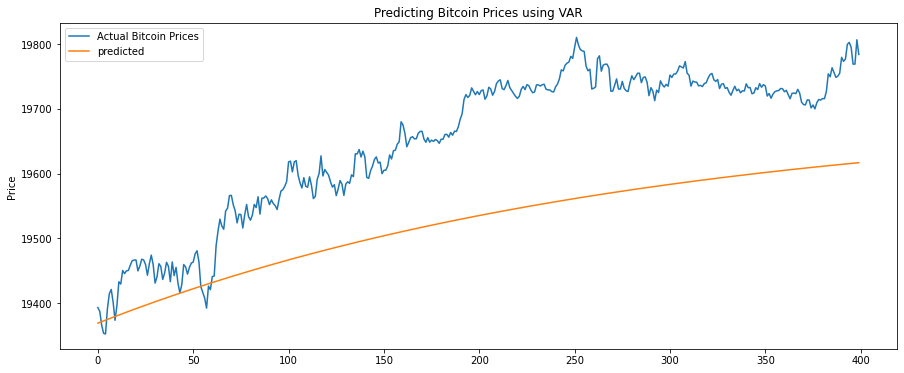

In [50]:
plt.figure(figsize=(15,6))
#var_prediction
x_range=range(len(data_senti_var_test))
#plt.plot(x_range,data_senti_var_test
plt.plot(x_range,data_senti_var_test.iloc[:,0], label='Actual Bitcoin Prices')
#plt.plot(x_range,pred_var,.iloc[:,0],label='predicted')
plt.plot(x_range,pred_var.iloc[:,0],label='predicted')
plt.title('Predicting Bitcoin Prices using VAR')
plt.ylabel('Price')
plt.legend()
plt.show()

## LSTM without sentiment influenced

In [51]:
#history_lstm_wo_senti=model_lstm_wo_senti.fit(x_train_lstm_wo_senti,y_train_lstm_wo_senti, epochs = 20, batch_size=32,callbacks=[es_callback])
pred_lstm_wo_senti= model_lstm_wo_senti.predict(x_test_lstm_wo_senti)
pred_lstm_wo_senti = scaler_lstm_wo_senti.inverse_transform(pred_lstm_wo_senti)


In [52]:
r2_score_lstm_wo_senti=r2_score(df_btc_1min.iloc[-394:-3,1],pred_lstm_wo_senti)

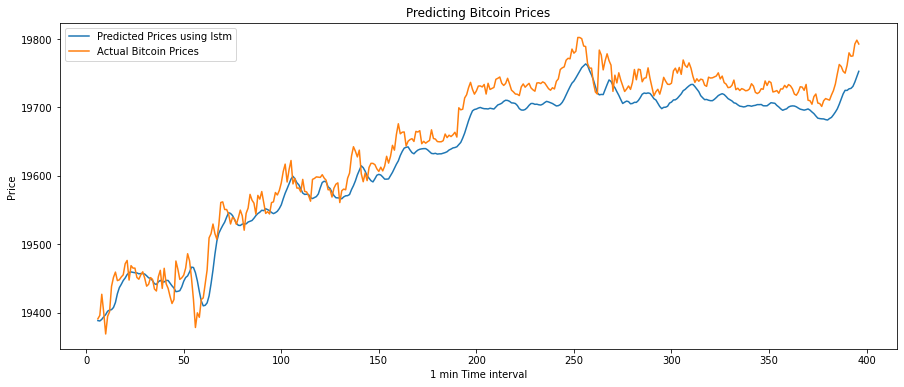

In [53]:
plt.figure(figsize=(15,6))
x_range=range(400)
plt.plot(x_range[6:-3],pred_lstm_wo_senti ,label="Predicted Prices using lstm")
plt.plot(x_range[6:-3],pd.to_numeric(df_btc_1min.iloc[-394:-3,1]),label='Actual Bitcoin Prices')
plt.title('Predicting Bitcoin Prices')
plt.xlabel('1 min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show()

## ARIMA

In [74]:
pred_arima_wo_senti = model_arima_wo_senti.predict(n_periods= 400,return_conf_int=True) 

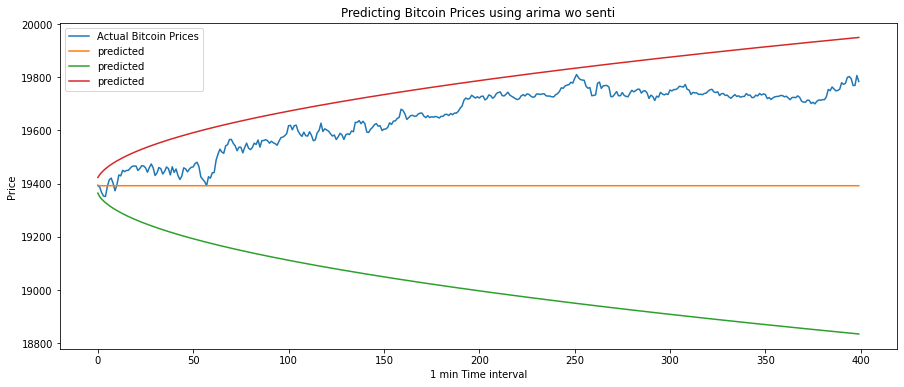

In [75]:
plt.figure(figsize=(15,6))
#x_range=range(400)
#x_range=range(883)
x_range=range(400)
plt.plot(x_range,df_btc_val_1min_arima_test,label='Actual Bitcoin Prices')
plt.plot(x_range,pred_arima_wo_senti[0],label='predicted')
plt.plot(x_range,pred_arima_wo_senti[1],label='predicted')
plt.title('Predicting Bitcoin Prices using arima wo senti')
plt.xlabel('1 min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show()
#pred_arima_wo_senti[1]

# **Real time prediction**

##  for lstm

In [56]:
def lstm_realt(data_btc_val,time_intervals_to_train=6,prediction_interval=3):
    scaler_val = MinMaxScaler(feature_range=(0,0.7))
    #scaler_fit= scaler_val.fit([[0],[100000]])
    scaled_data = scaler_val.fit_transform(data_btc_val['close'].values.reshape(-1,1))
    #scaled_data = scaler_fit.transform(data_btc_val['close'].values.reshape(-1,1))
    data_btc_val_scaled=scaled_data
    
    #to do: return test , train series from same function
    
    #to do: return scaler instance from create_sequence function along with test,train,x and y
    
    x=[]
    for i in range(time_intervals_to_train, len(data_btc_val)):
        x_i=list(data_btc_val_scaled[i - time_intervals_to_train: i, 0])
        x.append(x_i)
        
    x=np.array(x)
    x=np.reshape(x,(x.shape[0],x.shape[1],1))
    return np.array(x),scaler_val

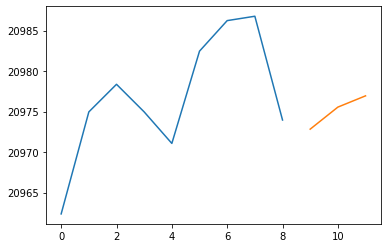

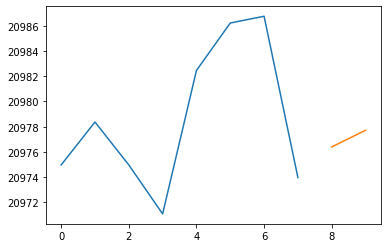

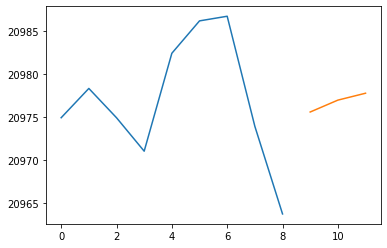

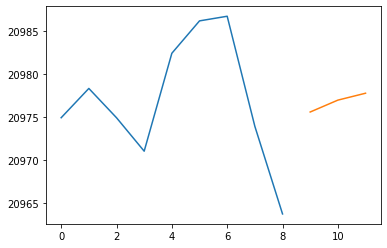

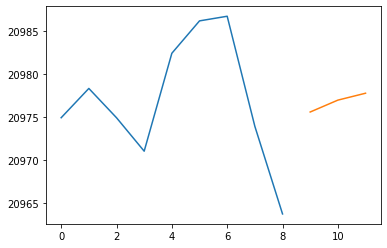

In [57]:
for i in range(5):
    start_time_lstm= datetime.datetime.now ()-datetime.timedelta(minutes=10)
    start_time_lstm=start_time_lstm.isoformat(sep=" ",timespec="seconds")
    end_time_lstm=datetime.datetime.now()
    end_time_lstm=end_time_lstm.isoformat(sep=" ",timespec="seconds")
    df_btc_lstm_realt=get_btc_val(interval="1min",start_date=str(start_time_lstm),end_date=str(end_time_lstm))
    #print(df_btc_lstm_realt)
    x_lstm_realt,scaler_val=lstm_realt(df_btc_lstm_realt)
    pred_realt_lstm =model_lstm_wo_senti.predict(x_lstm_realt)
    #pred_realt_lstm =model_lstm_wo_senti_realt.predict(x_lstm_realt)
    pred_realt_lstm=scaler_val.inverse_transform(pred_realt_lstm)
    
    x_range=range(15)
    x_mid=len(df_btc_lstm_realt.iloc[:,4])
    fig,ax=plt.subplots()
    
    plt.plot(x_range[:x_mid],pd.to_numeric(df_btc_lstm_realt.iloc[:,4]),label='Actual Bitcoin Prices')
    plt.plot(x_range[x_mid:x_mid+len(pred_realt_lstm)],  pred_realt_lstm,label="Predicted Prices") 
    
    plt.show()
    time.sleep(10)


## for arima

In [58]:
"""
start_time_lstm_train=datetime.datetime.now ()-datetime.timedelta(minutes=4010)
start_time_lstm_train=start_time_lstm_train.isoformat(sep=" ",timespec="seconds")
end_time_lstm_train=datetime.datetime.now ()-datetime.timedelta(minutes=10)
end_time_lstm_train=end_time_lstm_train.isoformat(sep=" ",timespec="seconds")
df_btc_lstm_realt_train=get_btc_val(interval="1min",start_date=str(start_time_lstm_train),end_date=str(end_time_lstm_train))
"""
start_time_arima_train=datetime.datetime.now ()-datetime.timedelta(minutes=4010)
start_time_arima_train=start_time_arima_train.isoformat(sep=" ",timespec="seconds")
end_time_arima_train=datetime.datetime.now ()-datetime.timedelta(minutes=10)
end_time_arima_train=end_time_arima_train.isoformat(sep=" ",timespec="seconds")
df_btc_arima_realt_train=get_btc_val(interval="1min",start_date=str(start_time_arima_train),end_date=str(end_time_arima_train))

In [59]:
df_btc_val_1min_arima_r=df_btc_arima_realt_train
df_btc_val_1min_arima_r['datetime']=pd.to_datetime(df_btc_val_1min_arima_r['datetime'])


In [60]:
df_btc_val_1min_arima_r=df_btc_val_1min_arima_r.set_index('datetime')
df_btc_val_1min_arima_r['close']=df_btc_val_1min_arima_r['close'].fillna(method='ffill')
df_btc_val_1min_arima_r.drop(["open","high","low"],axis=1,inplace=True)
df_btc_val_1min_arima_r=df_btc_val_1min_arima_r.astype(float)
df_btc_val_1min_arima_r=df_btc_val_1min_arima_r.resample('1T').mean()


In [61]:
model_arima_wo_senti_r=pm.auto_arima(df_btc_val_1min_arima_r["close"],
                                    m=0, seasonal=False,
                               start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32548.203, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32541.854, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32541.976, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32546.348, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=32543.527, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32540.654, Time=1.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32540.940, Time=1.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32543.826, Time=4.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32543.837, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32532.694, Time=10.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=32501.214, Time=6.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32530.223, Time=3.88 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=32502.725, Time=16.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=32502.613, Time=14.30 sec
 ARIMA(2,1,3)(0,

In [62]:
history_arima_wo_senti=model_arima_wo_senti_r.fit(df_btc_val_1min_arima_r)

In [63]:
pred_arima_wo_senti_r = model_arima_wo_senti_r.predict(n_periods= 13,return_conf_int=True) 

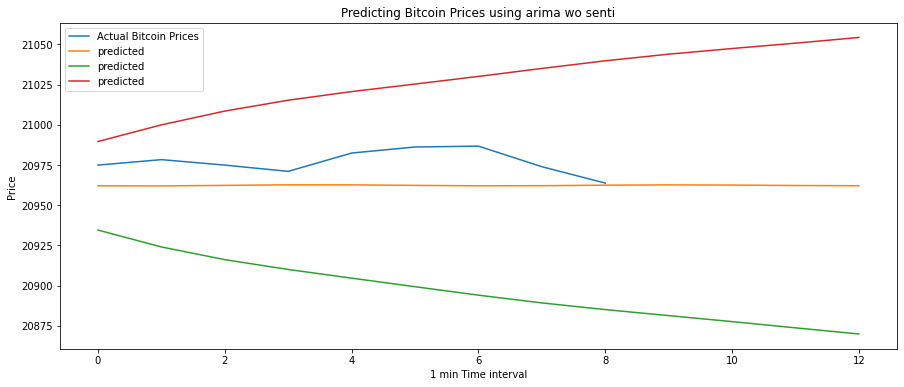

In [64]:
plt.figure(figsize=(15,6))
x_range=range(13)
plt.plot(x_range[:x_mid],pd.to_numeric(df_btc_lstm_realt.iloc[:,4]),label='Actual Bitcoin Prices')
plt.plot(x_range,pred_arima_wo_senti[0],label='predicted')
plt.plot(x_range,pred_arima_wo_senti[1],label='predicted')
plt.title('Predicting Bitcoin Prices using arima wo senti')
plt.xlabel('1 min Time interval')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Comparing models**

In [76]:
from sklearn.metrics import mean_absolute_error
print("mean absolute error for VAR ",mean_absolute_error(df_btc_1min.iloc[-400:,1],pred_var.iloc[:,0]))
print("mean absolute error for LSTM ",mean_absolute_error(df_btc_1min.iloc[-394:-3,1],pred_lstm_wo_senti))
print("mean absolute error for ARIMA middle bound ",mean_absolute_error(df_btc_1min.iloc[-400:,1],pred_arima_wo_senti[0]))
print("mean absolute error for ARIMA upper bound ",mean_absolute_error(df_btc_1min.iloc[-400:,1],pred_arima_wo_senti[1][:,1]))

mean absolute error for VAR  126.50991676501832
mean absolute error for LSTM  24.743036328324717
mean absolute error for ARIMA middle bound  255.0478840407755
mean absolute error for ARIMA upper bound  118.10908794320405
